# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_nopercolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['lock_16_project', 'block_16_project_BN']
    LAST_LAYER = 'block_16_project_BN'
    PREPROCESSING = tf.keras.applications.mobilenet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8229 - accuracy: 0.7295

947/947 [==============================] - 3698s 4s/step - loss: 0.8229 - accuracy: 0.7295 - val_loss: 9.8839 - val_accuracy: 0.6483
Epoch 2/200
947/947 [==============================] - 3261s 3s/step - loss: 0.7102 - accuracy: 0.7576 - val_loss: 10.2429 - val_accuracy: 0.6694
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6620 - accuracy: 0.7701

947/947 [==============================] - 3454s 4s/step - loss: 0.6620 - accuracy: 0.7701 - val_loss: 3.2705 - val_accuracy: 0.5941
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.6321 - accuracy: 0.7826

947/947 [==============================] - 3470s 4s/step - loss: 0.6321 - accuracy: 0.7826 - val_loss: 1.9749 - val_accuracy: 0.5909
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.6060 - accuracy: 0.7882

947/947 [==============================] - 3462s 4s/step - loss: 0.6060 - accuracy: 0.7882 - val_loss: 1.3580 - val_accuracy: 0.6862
Epoch 6/200
947/947 [==============================] - 3262s 3s/step - loss: 0.5859 - accuracy: 0.7950 - val_loss: 1.4159 - val_accuracy: 0.7251
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5678 - accuracy: 0.7982

947/947 [==============================] - 3469s 4s/step - loss: 0.5678 - accuracy: 0.7982 - val_loss: 0.7706 - val_accuracy: 0.7492
Epoch 8/200
947/947 [==============================] - 3261s 3s/step - loss: 0.5548 - accuracy: 0.8013 - val_loss: 4.0239 - val_accuracy: 0.4276
Epoch 9/200
947/947 [==============================] - 3255s 3s/step - loss: 0.5466 - accuracy: 0.8066 - val_loss: 1.0919 - val_accuracy: 0.7035
Epoch 10/200
947/947 [==============================] - 3248s 3s/step - loss: 0.5364 - accuracy: 0.8086 - val_loss: 1.1511 - val_accuracy: 0.7193
Epoch 11/200
947/947 [==============================] - 3249s 3s/step - loss: 0.5204 - accuracy: 0.8135 - val_loss: 1.0182 - val_accuracy: 0.7169
Epoch 12/200
947/947 [==============================] - 3241s 3s/step - loss: 0.5106 - accuracy: 0.8154 - val_loss: 1.0788 - val_accuracy: 0.7047
Epoch 13/200
947/947 [==============================] - 3248s 3s/step - loss: 0.5038 - accuracy: 0.8198 - val_loss: 0.8663 - val_accuracy: 

947/947 [==============================] - 3453s 4s/step - loss: 0.4417 - accuracy: 0.8407 - val_loss: 0.6610 - val_accuracy: 0.7955
Epoch 21/200
947/947 [==============================] - 3249s 3s/step - loss: 0.4398 - accuracy: 0.8421 - val_loss: 0.7389 - val_accuracy: 0.7892
Epoch 22/200
947/947 [==============================] - 3244s 3s/step - loss: 0.4328 - accuracy: 0.8421 - val_loss: 1.2505 - val_accuracy: 0.6365
Epoch 23/200
947/947 [==============================] - 3247s 3s/step - loss: 0.4256 - accuracy: 0.8462 - val_loss: 0.8802 - val_accuracy: 0.7658
Epoch 24/200
947/947 [==============================] - 3244s 3s/step - loss: 0.4213 - accuracy: 0.8463 - val_loss: 0.6935 - val_accuracy: 0.7583
Epoch 25/200
947/947 [==============================] - 3248s 3s/step - loss: 0.4135 - accuracy: 0.8501 - val_loss: 0.7661 - val_accuracy: 0.7844
Epoch 26/200
947/947 [==============================] - 3248s 3s/step - loss: 0.4073 - accuracy: 0.8524 - val_loss: 0.7783 - val_accuracy

947/947 [==============================] - 3443s 4s/step - loss: 0.4032 - accuracy: 0.8547 - val_loss: 0.5346 - val_accuracy: 0.8239
Epoch 28/200
947/947 [==============================] - 3662s 4s/step - loss: 0.3945 - accuracy: 0.8557 - val_loss: 0.5779 - val_accuracy: 0.8076
Epoch 29/200
947/947 [==============================] - 3888s 4s/step - loss: 0.3893 - accuracy: 0.8597 - val_loss: 0.5845 - val_accuracy: 0.8192
Epoch 30/200
947/947 [==============================] - 3681s 4s/step - loss: 0.3829 - accuracy: 0.8609 - val_loss: 0.6422 - val_accuracy: 0.7909
Epoch 31/200
947/947 [==============================] - 3757s 4s/step - loss: 0.3772 - accuracy: 0.8625 - val_loss: 0.9405 - val_accuracy: 0.7272
Epoch 32/200
947/947 [==============================] - 3744s 4s/step - loss: 0.3718 - accuracy: 0.8664 - val_loss: 0.6157 - val_accuracy: 0.8057
Epoch 33/200
947/947 [==============================] - 3601s 4s/step - loss: 0.3644 - accuracy: 0.8677 - val_loss: 0.7379 - val_accuracy

947/947 [==============================] - 3755s 4s/step - loss: 0.3279 - accuracy: 0.8778 - val_loss: 0.5170 - val_accuracy: 0.8365
Epoch 42/200
947/947 [==============================] - 3286s 3s/step - loss: 0.3267 - accuracy: 0.8792 - val_loss: 0.6979 - val_accuracy: 0.8098
Epoch 43/200
947/947 [==============================] - 3640s 4s/step - loss: 0.3222 - accuracy: 0.8804 - val_loss: 0.6053 - val_accuracy: 0.7995
Epoch 44/200
947/947 [==============================] - 3852s 4s/step - loss: 0.3169 - accuracy: 0.8824 - val_loss: 1.0858 - val_accuracy: 0.7765
Epoch 45/200
947/947 [==============================] - 3869s 4s/step - loss: 0.3114 - accuracy: 0.8865 - val_loss: 0.8989 - val_accuracy: 0.7790
Epoch 46/200
947/947 [==============================] - 3835s 4s/step - loss: 0.3133 - accuracy: 0.8857 - val_loss: 0.8276 - val_accuracy: 0.7212
Epoch 47/200
947/947 [==============================] - 3683s 4s/step - loss: 0.3093 - accuracy: 0.8854 - val_loss: 0.6126 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 443s 3s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9670434473456995,
 'basal cell carcinoma': 0.9807185451313011,
 'dermatofibroma': 0.9705056179775281,
 'melanoma': 0.9231945827007898,
 'nevus': 0.9662119480976864,
 'pigmented benign keratosis': 0.9858180288656451,
 'seborrheic keratosis': 0.9499860323720318,
 'solar lentigo': 0.9512934789893439,
 'squamous cell carcinoma': 0.9660150411615382,
 'vascular lesion': 0.9966423196511692}

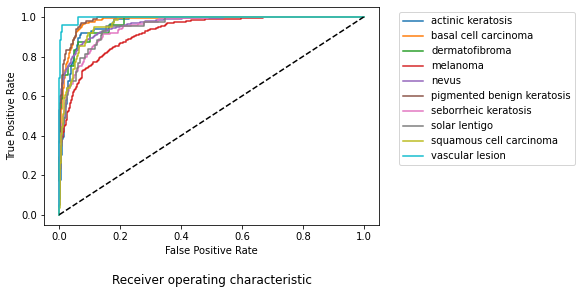

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

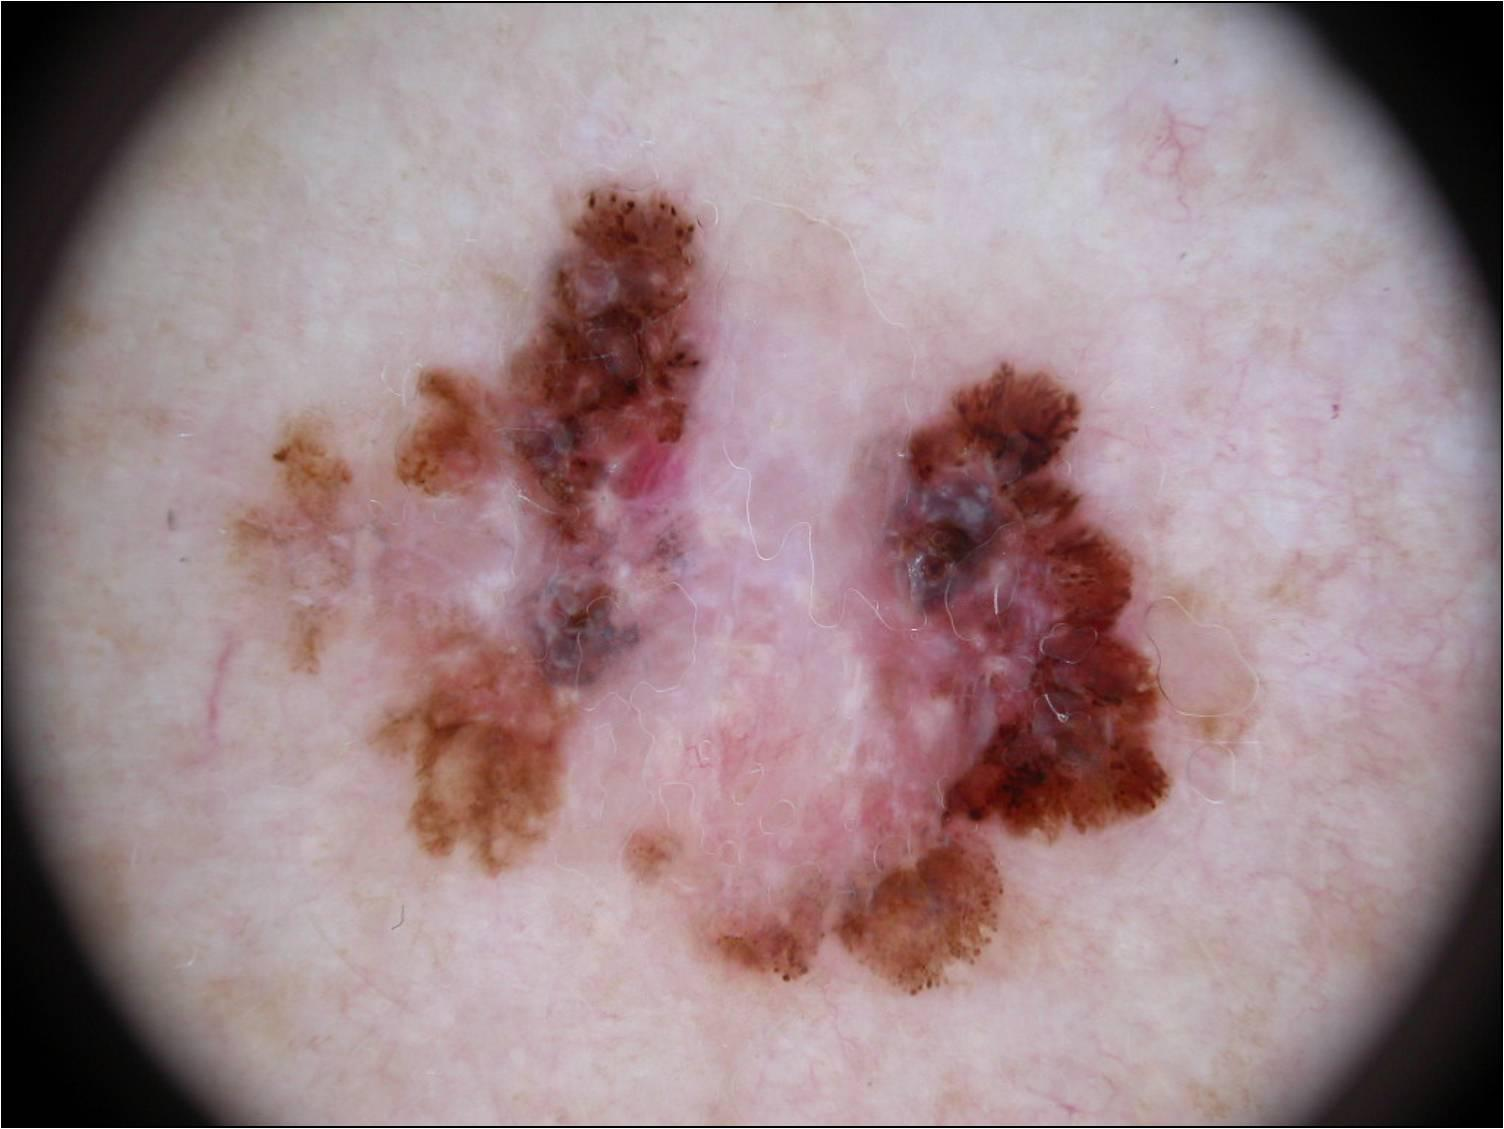

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

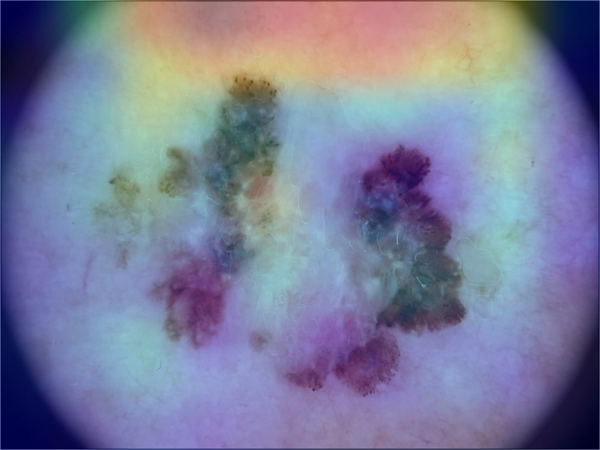

In [23]:
display_gradcam(melanoma_im_path, heatmap)